# Analyzing velocity and pumping with Pharaglow

## Importing packages

In [2]:
%matplotlib inline
import pandas as pd
import os
import numpy as np

# plotting
import matplotlib  as mpl
import matplotlib.pylab as plt

# image processing
import skimage
from skimage import io
from skimage.util import img_as_float
from skimage.filters import threshold_li
from scipy import ndimage
from skimage.morphology import remove_small_objects
from skimage.exposure import histogram
import json
import pims
import trackpy as tp

# our packages
from pharaglow import extract, util
from pharaglow.util import smooth

## Directing path options and variables (CHANGE NAMES OR YOUR FILES ARE OVERWRITTEN)

In [3]:
# ADD DIRECTORY OF STRAIN MASTER FOLDER(S)
ctrl = ""
INF100 = ""
INF102 = ""

# IS THERE A LAWN?
lawn = 'Yes' #or 'No'
print('Is there a lawn?', lawn)

# FPS?
fps = 30
print('fps:', fps)

# HOW MANY MICRONS PER PIXEL?
umPerPx = 2.34

# FIGURE NAMES
# all_velocities = "/home/nzjacic/Desktop/Rough_figures/10X_INF100/10x_INF100.5_all_velocities.pdf"
# averaged_velocities = "/home/nzjacic/Desktop/Rough_figures/10x_INF100/10x_INF100.5_combined_averaged_velocities.pdf"
# entry_trajectory = "/home/nzjacic/Desktop/Rough_figures/10X_INF100/10x_INF100.5_entries_trajectories.pdf"

Is there a lawn? Yes
fps: 30


## Defining functions

### Defining function to prepare binary of lawn image

In [4]:
def prepLawn(filename):
    # outlining lawn and turning into binary - thresholding with li (CHANGE NAME)
    image = img_as_float(skimage.io.imread(filename)).astype(np.float64)
    thresh = threshold_li(image)
    binary = image > thresh
    # troubleshooting images with noise around the lawn (optional)
    binary = remove_small_objects(binary, min_size = 5000, connectivity = 2) #change min_size 
    # filling small holes in the lawn
    binary = ndimage.binary_fill_holes(binary).astype(int)
    return binary

### Defining functions to extract velocity, pumping and kymo (?)

In [5]:
def getVelocity(traj, umperPx, fps):
    return np.sqrt((np.diff(traj['x'])**2+np.diff(traj['y'])**2))/np.diff(traj['frame'])*umperPx*fps

def getPumps(traj):
    return extract.bestMatchPeaks(traj['pumps'])

def getKymo(df, key):
    kymo = np.sum([np.array(list(filter(None.__ne__,row))) for row in df[key].values], axis=2)
    kymo = np.array([np.interp(np.linspace(0, len(row), 100), np.arange(len(row)), np.array(row)) \
                      for row in kymo])
    kymo = extract.alignKymos(kymo).T
    return kymo

### Defining how Python reads in Pharaglow and lawn data

In [17]:
%%time
def readData(dataFolder, umPerPx, fps, j = 0, nmax = None):
    df = {}
    lawnImages = {}
    path = os.path.dirname(dataFolder)
    for fn in os.listdir(path):
        if nmax != None and len(df.keys())>nmax-1:
            break
        file = os.path.join(path,fn)
        if os.path.isfile(file) and 'results_' in fn and fn.endswith('.json'):
            print('Reading', file)
            particle_index = int(fn.split('.')[0].split('_')[-1])
            traj =  pd.read_json(file, orient='split', numpy = True)
            # velocity
            t = traj['frame']/fps
            v = getVelocity(traj, umPerPx, fps)
            p, pump, pks, roc  = getPumps(traj)
            # interpolate the pumping rate
            pumpingrate = fps/np.diff(p)
            pumpInterp = np.interp(traj['frame'], p[:-1], pumpingrate, left = 0, right = 0)
            # get kymo
            kymo = getKymo(traj, 'Straightened')
            df[j] = {'time': t,
                     'x': traj['x'],
                     'y': traj['y'],
                             'velocity':v,
                             'peaks': p,
                             'pumpTrace':pump.values,
                             'pumpRate':pumpingrate,
                             'pumpInterpolated': pumpInterp,
                             'inside': traj['inside'],
                             'pid':particle_index,
                             'filename': fn,
                             'kymo': kymo
                                 }
            j +=1
            # creating dictionary of lawn images based on exp.ID if necessary
#             if lawn == 'Yes':
#                 lawnfile = particle_index
#                 if lawnfile not in lawnImages.keys():
#                     lawnpath = '/media/scholz_la/hd2/Nicolina/Lawns/'
#                     lawnImages[lawnfile] = prepLawn(os.path.join(lawnpath, lawnfile+'_lawn.tiff') or os.path.join(lawnpath, lawnfile+'_lawn.bmp'))
#                     print(lawnfile)
    return df

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 15.3 µs


## Plotting

### Reading in Pharaglow results for different strains/conditions

In [18]:
%%time

# Making dictionary combining data with strain name in their separate master folders
Data = {}
for strainName, folder in zip(['Control', 'INF100', 'INF102'], [ctrl, INF100, INF102]):
    Data[strainName] = readData(folder, umPerPx, fps, nmax = 1)

# # control
# ctrlData = ctrlData.update(readData(folder, umPerPx, fps, j = j))

# # strain 1 - INF100
# INF100Data ={}
# j = 0
# for folder in INF100:
#     INF100Data.update(readData(folder, umPerPx, fps, j = j))
#     j = max(INF100Data.keys())+1

Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/test/20200320_NZ0045_test_results_0.json


/home/nzjacic/.conda/envs/pumping/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: the 'numpy' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'numpy'
  if sys.path[0] == '':


Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_GRU101_RFP_24hr/test/20200320_NZ0045_test_results_1.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_INF100/20200326_NZ0046_test_results_0.json
Reading /media/scholz_la/hd2/Nicolina/Pharaglow/Old_files/Pharaglow_v5/10x_INF100/20200326_NZ0046_test_results_1.json
CPU times: user 1min 10s, sys: 6.51 s, total: 1min 16s
Wall time: 1min 16s


### Extract velocity and pumping for all conditions

Beginning analysis for Control:
Control trajectory 1
Plotting Control...
Beginning analysis for INF100:
INF100 trajectory 0
Plotting INF100...
Ta da!


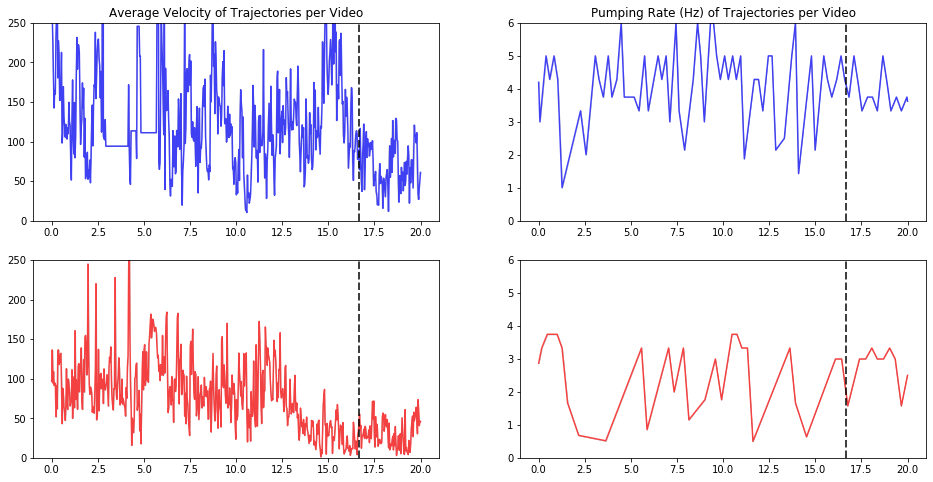

In [30]:
# color dictionary
colors = {
    'INF100':'red',
    'Control':'blue',
    'INF102' : 'green'
}
# assigning time before entry (dt) and time after entry (da)
dt = 1200
da = 300
# change number of rows to the number of strains
f1 = plt.figure(figsize = (16,8))
grid = mpl.gridspec.GridSpec(ncols=2, nrows =3)
# setting up subplots for velocity (a) and pumping (b) - add as number of strains increase
# velocity
ax1a = f1.add_subplot(grid[0,0])
ax2a = f1.add_subplot(grid[1,0])
ax3a = f1.add_subplot(grid[2,0])
axa = [ax1a, ax2a, ax2b]
# pumping
ax1b = f1.add_subplot(grid[0,1])
ax2b = f1.add_subplot(grid[1,1])
ax3b = f1.add_subplot(grid[2,1])
axb = [ax1b, ax2b, ax3b]

# plotting velocity and pumping
if lawn is 'Yes':
    # goes through each condition
    for ci, condition in enumerate(Data.keys()):
        print('Beginning analysis for', condition+':')
        # lists needed for plotting
        cutVelocities = []
        pumpingrates = []
        pumpingInterp = []
        # goes through each worm
        for idx in Data[condition].keys():
            f = (Data[condition][idx]['inside']).mean()
            if f<0.9 and f>0.01:
                t0 = np.where(Data[condition][idx]['inside'] ==1)[0][0]
                if t0>dt and t0-dt>0 and t0+da<len(Data[condition][idx]['time']):
                    print(condition, 'trajectory', idx)
                    # velocity variables
                    time = np.linspace(0, (dt+da)/fps, dt+da)
                    cutVelocities.append(Data[condition][idx]['velocity'][t0-dt:t0+da])
                    # pumping variables
                    #pi = Data[condition][idx]['peaks'].values/fps
                    #pumpingrate = fps/np.diff(Data[condition][idx]['peaks'].values)
                    pumpingrates.append(Data[condition][idx]['pumpInterpolated'][t0-dt:t0+da])
                    #pumpingInterp.append(np.interp(time, pi[:-1], pumpingrates[-1], left = 0, right = 0))
        print ('Plotting', condition+'...')
        # average velocity across all trajectories and all movies per strain
        mv, sv = np.mean(np.array(cutVelocities), axis =0), np.std(np.array(cutVelocities), axis =0)
        axa[ci].plot(time, mv, color = colors[condition], alpha = 0.7)
        axa[ci].fill_between(np.arange(len(mv))/fps, mv-sv, mv+sv, 
                             color = 'gray', alpha = 0.3)
        axa[ci].axvline(x = dt/fps, color = 'black', dashes = (5, 2))
        # average pumping rate across all trajectories and all movies per strain
        mp, sp = np.mean(np.array(pumpingrates), axis =0), np.std(np.array(pumpingrates), axis =0)
        axb[ci].plot(time, mp, color = colors[condition], alpha = 0.6)
        axb[ci].fill_between(np.arange(len(mp))/fps, mp-sp, mp+sp, 
                 color = 'gray', alpha = 0.3)
        axb[ci].plot(time, smooth(pumpingrates, 10), 'black', lw =2)
        axb[ci].axvline(x = dt/fps, color = 'black', dashes = (5, 2))
# making things pretty
# axes
ax1a.set_ylim(0,250)
ax1b.set_ylim(0,6)
ax2a.set_ylim(0,250)
ax2b.set_ylim(0,6)
# labels
ax1a.set_title('Average Velocity of Trajectories per Video')
ax1b.set_title('Pumping Rate (Hz) of Trajectories per Video')

print('Ta da!')

Beginning analysis for Control:
Control trajectory 8
Control trajectory 10
Control trajectory 12
Plotting Control...
Beginning analysis for INF100:
INF100 trajectory 0
INF100 trajectory 2
INF100 trajectory 3
INF100 trajectory 4
Plotting INF100...
Ta da!


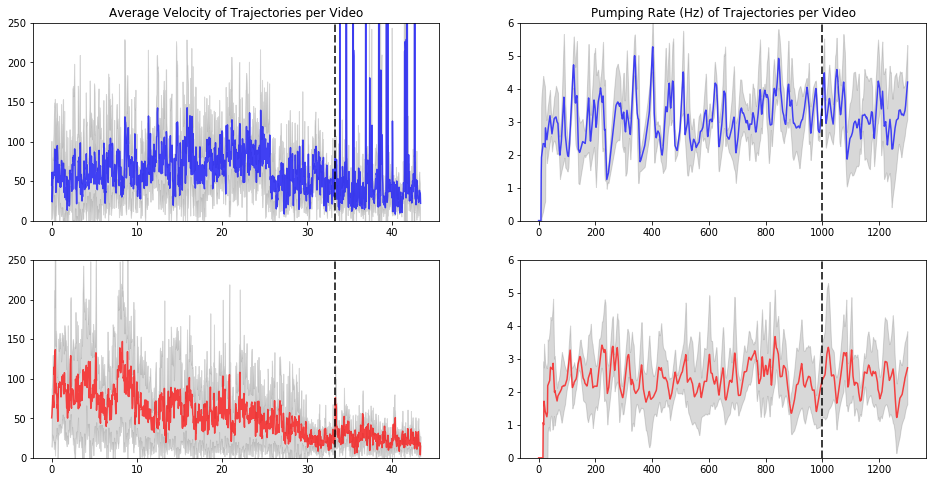

In [223]:
# color dictionary
colors = {
    'INF100':'red',
    'Control':'blue'
}
# assigning time before entry (dt) and time after entry (da)
dt = 1000
da = 300
# change number of rows to the number of strains
f1 = plt.figure(figsize = (16,8))
grid = mpl.gridspec.GridSpec(ncols=2, nrows =2)
# setting up subplots for velocity (a) and pumping (b) - add as number of strains increase
# velocity
ax1a = f1.add_subplot(grid[0,0])
ax2a = f1.add_subplot(grid[1,0])
axa = [ax1a, ax2a]
# pumping
ax1b = f1.add_subplot(grid[0,1])
ax2b = f1.add_subplot(grid[1,1])
axb = [ax1b, ax2b]

# plotting velocity and pumping
if lawn is 'Yes':
    # goes through each condition
    for ci, condition in enumerate(Data.keys()):
        print('Beginning analysis for', condition+':')
        # lists needed for plotting
        cutVelocities = []
        pumpingrates = []
        pumpingInterp = []
        # goes through each worm
        for idx in Data[condition].keys():
            f = (Data[condition][idx]['inside']).mean()
            if f<0.9 and f>0.01:
                t0 = np.where(Data[condition][idx]['inside'] ==1)[0][0]
                if t0>dt and t0-dt>0 and t0+da<len(Data[condition][idx]['time']):
                    print(condition, 'trajectory', idx)
                    # velocity variables
                    timeS = np.linspace(0, (dt+da)/fps, dt+da)
                    cutVelocities.append(Data[condition][idx]['velocity'][t0-dt:t0+da])
                    # pumping variables
                    timeF = np.linspace(0, dt+da, dt+da)
                    pi = Data[condition][idx]['peaks'].values
                    pumpingrate = 30/np.diff(Data[condition][idx]['peaks'].values)
                    pumpingrates.append(pumpingrate)
                    pumpingInterp.append(np.interp(timeF, pi[:-1], pumpingrates[-1], left = 0, right = 0))
        print ('Plotting', condition+'...')
        # average velocity across all trajectories and all movies per strain
        mv, sv = np.mean(np.array(cutVelocities), axis =0), np.std(np.array(cutVelocities), axis =0)
        axa[ci].plot(timeS, mv, color = colors[condition], alpha = 0.7)
        axa[ci].fill_between(np.arange(len(mv))/fps, mv-sv, mv+sv, 
                             color = 'gray', alpha = 0.3)
        axa[ci].axvline(x = dt/fps, color = 'black', dashes = (5, 2))
        # average pumping rate across all trajectories and all movies per strain
        mp, sp = np.mean(np.array(pumpingInterp), axis =0), np.std(np.array(pumpingInterp), axis =0)
        axb[ci].plot(timeF, mp, color = colors[condition], alpha = 0.7)
        axb[ci].fill_between(np.arange(len(mp)), mp-sp, mp+sp, 
                 color = 'gray', alpha = 0.3)
        axb[ci].axvline(x = dt, color = 'black', dashes = (5, 2))
# making things pretty
# axes
ax1a.set_ylim(0,250)
ax1b.set_ylim(0,6)
ax2a.set_ylim(0,250)
ax2b.set_ylim(0,6)
# labels
ax1a.set_title('Average Velocity of Trajectories per Video')
ax1b.set_title('Pumping Rate (Hz) of Trajectories per Video')

print('Ta da!')

In [220]:
print(Data[condition][idx]['time'])

8403    280.100000
8404    280.133333
8405    280.166667
8406    280.200000
8407    280.233333
           ...    
8925    297.500000
8926    297.533333
8927    297.566667
8928    297.600000
8929    297.633333
Name: frame, Length: 527, dtype: float64


NameError: name 'traj' is not defined

In [161]:
print(len(pi))
print(len(time))
print(len(pumpingrate))
print(pumpingrates)
print(pumpingInterp[-2])
print(len(pumpingInterp[-2]))
print(cutVelocities)

294
1500
293
[array([0.56603774, 1.66666667, 3.75      , 1.15384615, 3.75      ,
       3.75      , 3.33333333, 1.875     , 1.07142857, 1.36363636,
       5.        , 0.85714286, 4.28571429, 0.90909091, 3.33333333,
       0.81081081, 2.        , 0.39473684, 3.33333333, 0.83333333,
       3.33333333, 3.75      , 2.5       , 1.        , 0.85714286,
       3.33333333, 3.        , 3.75      , 1.57894737, 1.76470588,
       0.44117647, 3.        , 3.33333333, 3.33333333, 3.33333333,
       3.75      , 1.57894737, 3.75      , 3.33333333, 3.        ,
       1.2       , 3.33333333, 3.33333333, 1.2       , 1.66666667,
       1.76470588, 3.33333333, 3.75      , 3.75      , 3.75      ,
       3.33333333, 1.66666667, 0.68181818, 0.51724138, 3.33333333,
       0.85714286, 3.33333333, 2.        , 3.33333333, 1.15384615,
       1.76470588, 3.        , 1.76470588, 3.75      , 3.75      ,
       3.33333333, 3.33333333, 0.5       , 3.33333333, 1.66666667,
       0.63829787, 3.        , 3.        , 1.578